In [ ]:
!nvidia-smi

Fri Jun  3 07:38:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import pickle
from keras.models import model_from_json
from keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_hub as hub

In [ ]:
IMAGE_SHAPE = (224, 224)
EPOCHS = 10

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
data_root=("/content/drive/MyDrive/Dataset/Rice Leaf Disease Image Samples/Rice Leaf Disease Images")

In [ ]:
TRAINING_DATA_DIR = str(data_root)

In [ ]:
datagen_kwargs = dict(rescale=1./255, validation_split=.20)

In [ ]:
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)

valid_generator = valid_datagen.flow_from_directory(TRAINING_DATA_DIR, subset= 'validation', shuffle=True, target_size=IMAGE_SHAPE)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)

train_generator = train_datagen.flow_from_directory(TRAINING_DATA_DIR,subset='training',shuffle=True,target_size=IMAGE_SHAPE)

Found 1310 images belonging to 5 classes.
Found 5248 images belonging to 5 classes.


In [ ]:
for image_batch, label_batch in train_generator:
    break
image_batch.shape, label_batch.shape

((32, 224, 224, 3), (32, 5))

In [ ]:
print (train_generator.class_indices)

{'Bacterialblight': 0, 'Blast': 1, 'Brownspot': 2, 'Healthy': 3, 'Tungro': 4}


In [ ]:
labels = '\n'.join(sorted(train_generator.class_indices.keys()))
with open('labels.txt', 'w') as f:
 f.write(labels)
!cat labels.txt

Bacterialblight
Blast
Brownspot
Healthy
Tungro

In [ ]:
model = tf.keras.Sequential([
  hub.KerasLayer('https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4', 
  output_shape=[1280],
  trainable=False),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')])
model.build([None, 224, 224, 3])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(
 optimizer=optimizer,
 loss='categorical_crossentropy',
 metrics=['accuracy', 
          tf.keras.metrics.Recall(),
          tf.keras.metrics.Precision()])

In [ ]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)
history = model.fit(train_generator, 
   epochs=EPOCHS,
   verbose=1,
   steps_per_epoch=steps_per_epoch,
   validation_data=valid_generator,
   validation_steps=val_steps_per_epoch)

Epoch 1/10
164/164 [==============================] - 1009s 6s/step - loss: 0.4829 - accuracy: 0.8175 - recall: 0.7748 - precision: 0.8673 - val_loss: 0.1789 - val_accuracy: 0.9382 - val_recall: 0.9176 - val_precision: 0.9509
Epoch 2/10
164/164 [==============================] - 182s 1s/step - loss: 0.1816 - accuracy: 0.9354 - recall: 0.9247 - precision: 0.9469 - val_loss: 0.1201 - val_accuracy: 0.9641 - val_recall: 0.9618 - val_precision: 0.9692
Epoch 3/10
164/164 [==============================] - 177s 1s/step - loss: 0.1248 - accuracy: 0.9596 - recall: 0.9533 - precision: 0.9651 - val_loss: 0.0900 - val_accuracy: 0.9733 - val_recall: 0.9733 - val_precision: 0.9770
Epoch 4/10
164/164 [==============================] - 175s 1s/step - loss: 0.1045 - accuracy: 0.9667 - recall: 0.9611 - precision: 0.9704 - val_loss: 0.0721 - val_accuracy: 0.9786 - val_recall: 0.9763 - val_precision: 0.9793
Epoch 5/10
164/164 [==============================] - 177s 1s/step - loss: 0.0862 - accuracy: 0.972

In [ ]:
final_loss, final_accuracy, final_recall, final_precision = model.evaluate(valid_generator, steps = val_steps_per_epoch)
print('Final loss: {:.2f}'.format(final_loss))
print('Final accuracy: {:.2f}%'.format(final_accuracy * 100))
print('Final Recall: {:.2f}%'.format(final_recall * 100))
print('Final Precision: {:.2f}%'.format(final_precision * 100))

41/41 [==============================] - 36s 875ms/step - loss: 0.0303 - accuracy: 0.9924 - recall: 0.9916 - precision: 0.9931
Final loss: 0.03
Final accuracy: 99.24%
Final Recall: 99.16%
Final Precision: 99.31%


In [ ]:
final_f1_score = (2 * final_recall * final_precision) / (final_recall + final_precision)
print('Final F-score: {:.2f}%'.format(final_f1_score * 100))

Final F-score: 99.24%


In [ ]:
acc = history.history
print(acc)

{'loss': [0.48286736011505127, 0.18160802125930786, 0.12477261573076248, 0.1044551208615303, 0.08620305359363556, 0.07716061174869537, 0.07105604559183121, 0.0710887461900711, 0.057112064212560654, 0.05352269858121872], 'accuracy': [0.8174542784690857, 0.9354039430618286, 0.9596036672592163, 0.9666539430618286, 0.9725610017776489, 0.9740853905677795, 0.9759908318519592, 0.9771341681480408, 0.9811356663703918, 0.9830411672592163], 'recall': [0.7747713327407837, 0.9247332215309143, 0.9533155560493469, 0.9611280560493469, 0.9698932766914368, 0.9716082215309143, 0.9742758870124817, 0.9744664430618286, 0.9784680008888245, 0.9817073345184326], 'precision': [0.8673208355903625, 0.9469268321990967, 0.9650848507881165, 0.9703732132911682, 0.975095808506012, 0.9773816466331482, 0.9785646200180054, 0.979130744934082, 0.982775092124939, 0.9845213294029236], 'val_loss': [0.17892560362815857, 0.12005972862243652, 0.09000647813081741, 0.07209279388189316, 0.07186171412467957, 0.05656346306204796, 0.0

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

recall = history.history['recall']
val_recall = history.history['val_recall']

precision = history.history['precision']
val_precision = history.history['val_precision']

f1_score = (2 * np.array(history.history['precision']) * np.array(history.history['recall'])) / (np.array(history.history['precision']) + np.array(history.history['recall']))
val_final_f1_score = (2 * np.array(history.history['val_precision']) * np.array(history.history['val_recall'])) / (np.array(history.history['val_precision']) + np.array(history.history['val_recall']))

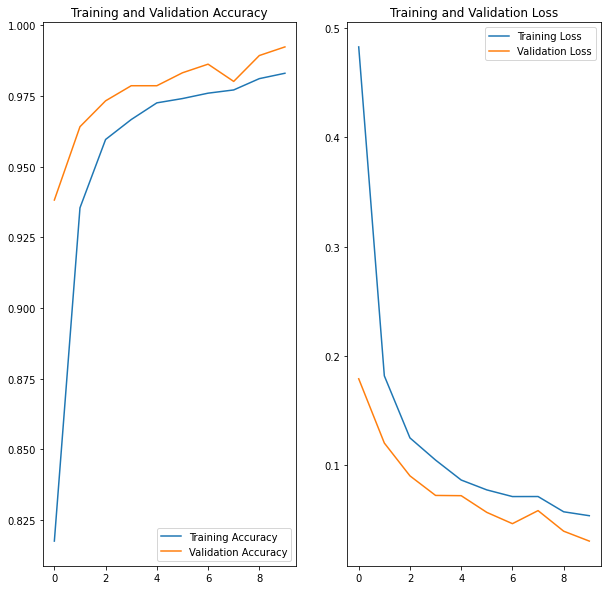

In [ ]:
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

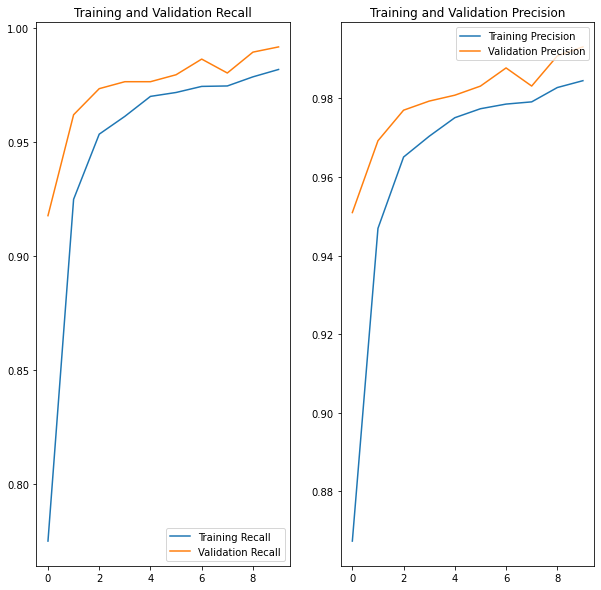

In [ ]:
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), recall, label='Training Recall')
plt.plot(range(EPOCHS), val_recall, label='Validation Recall')
plt.legend(loc='lower right')
plt.title('Training and Validation Recall')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), precision, label='Training Precision')
plt.plot(range(EPOCHS), val_precision, label='Validation Precision')
plt.legend(loc='upper right')
plt.title('Training and Validation Precision')
plt.show()

Text(0.5, 1.0, 'Training and Validation F1-Score')

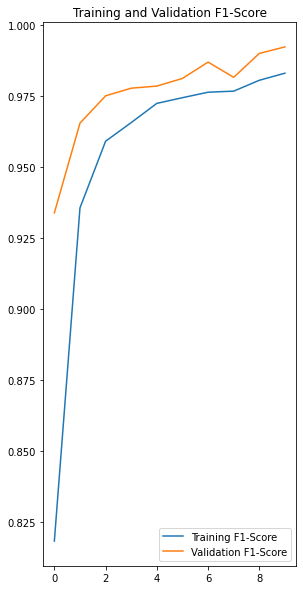

In [ ]:
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), f1_score, label='Training F1-Score')
plt.plot(range(EPOCHS), val_final_f1_score, label='Validation F1-Score')
plt.legend(loc='lower right')
plt.title('Training and Validation F1-Score')